# Data wrangling

In this notebook, we will preprocess the datasets that were extracted from MIMIC-III database.

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import seaborn as sns
import urllib.request, urllib.parse, urllib.error
import zipfile

# for pretty printing pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('seaborn-notebook')

In [5]:
# generate a data folder, we store all data in this folder
if not os.path.exists('data'):
    os.makedirs('data')
    
# download and unzip the rawdata
url = 'https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdk96S3k0djAydHpndFVwbU1vY1YxSTF6VmJBX2c/root/content'
urllib.request.urlretrieve(url, "download.zip")

with zipfile.ZipFile("download.zip","r") as zip_ref:
    zip_ref.extractall("data/rawdata")

## Data collection

The datasets are stored in CSV format in the 'data/rawdata' folder.

In [6]:
def get_path(filename, suffix):
    """Return the path
    
    Args: 
        filename (string): name of the file
        suffix (string): extension of the file
        
    Returns:
        path
    """
    # Join the path for "data" folder
    cwd = os.getcwd()
    dir_name = os.path.join(cwd, 'data/rawdata')
    
    return os.path.join(dir_name, filename + "." + suffix)

#### Collect the feature data that are the multivariate time series
The features are stored in *chartdata*, *labdata*, and *outputdata* CSV files. First, we load the data from these three files.

In [7]:
# get filenames
filenames = ['chartdata',"labdata", "outputdata"]
paths = [get_path(filename, 'csv') for filename in filenames]

# Read and store data into a list
rawdata = []
for path in paths:
    df = pd.read_csv(path, index_col=0, converters={'intime':np.datetime64}, engine='python')
    df.loc[:, 'time'] = pd.to_timedelta(df.loc[:, 'time']) # cast the dtype to timedelta
    rawdata.append(df)

Print the info of the data and the first few rows of the data.

In [8]:
# print the data types
for i, filename in enumerate(filenames):
    print("Data types in {} are: \n".format(filename), rawdata[i].dtypes, "\n")
    print("First 5 rows of {} are:\n".format(filename), rawdata[i].head(), "\n")

Data types in chartdata are: 
 icustay_id              int64
intime         datetime64[ns]
time          timedelta64[ns]
category               object
valuenum              float64
dtype: object 

First 5 rows of chartdata are:
    icustay_id              intime     time    category  valuenum
0      200003 2199-08-02 19:50:04 00:09:56         GCS       5.0
1      200003 2199-08-02 19:50:04 00:09:56  heart rate     119.0
2      200003 2199-08-02 19:50:04 00:09:56   resp_rate      35.0
3      200003 2199-08-02 19:50:04 00:09:56      sys_BP      91.0
4      200003 2199-08-02 19:50:04 01:09:56  heart rate     122.0 

Data types in labdata are: 
 icustay_id              int64
intime         datetime64[ns]
time          timedelta64[ns]
category               object
valuenum              float64
dtype: object 

First 5 rows of labdata are:
    icustay_id              intime              time   category  valuenum
0      200003 2199-08-02 19:50:04 -1 days +21:49:56  BILIRUBIN       3.5
1      2

We concatenate these dataframes along axis=0. Also, we convert the 'time' column from timedelta type by adding the current date.

In [9]:
# concatenate the rawdata
df = pd.concat(rawdata)
df['time'] = df['time'] + datetime.date.today() # convert the timedelta to datetime 

# Print the resulted dataframe
df.head()

,icustay_id,intime,time,category,valuenum
0,200003,2199-08-02 19:50:04,2017-10-11 00:09:56,GCS,5.0
1,200003,2199-08-02 19:50:04,2017-10-11 00:09:56,heart rate,119.0
2,200003,2199-08-02 19:50:04,2017-10-11 00:09:56,resp_rate,35.0
3,200003,2199-08-02 19:50:04,2017-10-11 00:09:56,sys_BP,91.0
4,200003,2199-08-02 19:50:04,2017-10-11 01:09:56,heart rate,122.0


We then pivot the table by passing columns as category such that each row shows all variables of one observation, which is a step closer to the tidy data.

In [11]:
# apply pivot to the df
feature_df = df.pivot_table('valuenum', index=['icustay_id', 'time'], columns='category')
feature_df = feature_df.sort_index()
feature_df.head()

category                        BILIRUBIN   BUN  FIO2  GCS  HCO3  PO2   WBC  \
icustay_id time                                                               
200003     2017-10-10 21:49:56        3.5  21.0   NaN  NaN  23.0  NaN  14.8   
           2017-10-11 00:09:56        NaN   NaN   NaN  5.0   NaN  NaN   NaN   
           2017-10-11 00:24:56        NaN   NaN   NaN  NaN   NaN  NaN   NaN   
           2017-10-11 01:09:56        NaN   NaN   NaN  NaN   NaN  NaN   NaN   
           2017-10-11 01:34:56        NaN   NaN   NaN  NaN   NaN  NaN   NaN   

category                        heart rate  potassium  resp_rate  sodium  \
icustay_id time                                                            
200003     2017-10-10 21:49:56         NaN        3.1        NaN   140.0   
           2017-10-11 00:09:56       119.0        NaN       35.0     NaN   
           2017-10-11 00:24:56         NaN        NaN        NaN     NaN   
           2017-10-11 01:09:56       122.0        NaN       34.0     NaN   
           2017-10-11 01:34:56       115.0        NaN       33.0     NaN   

category                        sys_BP  temperature  urine_out  
icustay_id time                                                 
200003     2017-10-10 21:49:56     NaN          NaN        NaN  
           2017-10-11 00:09:56    91.0          NaN        NaN  
           2017-10-11 00:24:56     NaN          NaN      230.0  
           2017-10-11 01:09:56    81.0         39.0        NaN  
           2017-10-11 01:34:56    98.0          NaN        NaN

#### Collect the target data including label and SAPS-II score

The label and SAPS-II score are stored in *patient_details* and *sapsii_score* files. We load the data from these two files, and then combine them together.

In [12]:
# load the patient details from file 
path = get_path('patient_details', 'csv')
patient_df = pd.read_csv(path, index_col=0)
patient_df = patient_df.set_index('icustay_id').sort_index()
patient_df.head()

,subject_id,hadm_id,gender,dbsource,age,intime,los,survival,in_hospital_death,height_avg,weight_avg
icustay_id,,,,,,,,,,,
200003,27513,163557,M,carevue,48.30,2199-08-02 19:50:04,19.97,75.17,0,NaN,46.4
200007,20707,129310,M,carevue,43.35,2109-02-17 10:03:37,3.24,-1.00,0,153.7,79.9
200014,9514,127229,M,carevue,84.73,2105-02-16 23:16:48,4.60,10.03,0,172.7,96.5
200019,21789,112486,F,carevue,82.88,2178-07-08 09:03:12,2.90,2.62,1,NaN,72.9
200021,61691,109307,M,metavision,60.85,2114-12-26 19:45:12,1.95,-1.00,0,NaN,63.0


In [13]:
# load the patient SAPS-II score
path = get_path('sapsii_score', 'csv')
sapsii_df = pd.read_csv(path, index_col=0)
sapsii_df = sapsii_df.set_index('icustay_id').sort_index()

# convert the probaility to labeling
sapsii_df['sapsii_prediction'] = np.where(sapsii_df['sapsii_prob']>0.5, 1, 0)
sapsii_df.head()

,sapsii_prob,sapsii_prediction
icustay_id,,
200003,0.106398,0
200007,0.029295,0
200014,0.305597,0
200019,0.552904,1
200021,0.326364,0


In [14]:
# Create a dataframe
feature_index = np.sort(feature_df.index.get_level_values('icustay_id').unique().values)
target_df = pd.DataFrame(index = feature_index)
target_df.index.name = 'icustay_id'

# Merge the patient_df and sapsii_df together
target_df = pd.concat([target_df, patient_df['in_hospital_death'], sapsii_df], axis = 1, join_axes=[target_df.index])
target_df.head()

,in_hospital_death,sapsii_prob,sapsii_prediction
icustay_id,,,
200003,0,0.106398,0
200007,0,0.029295,0
200014,0,0.305597,0
200019,1,0.552904,1
200021,0,0.326364,0


## Data cleaning

### Copy the patient's age to the feature

We copy the age from *patient_df* to *feature_df*. Since the length of ICU stays is short compared to the age, so we can assume the age is a constant in the time series.

In [15]:
feature_df = pd.merge(feature_df.reset_index(), patient_df['age'].reset_index(), 
                      on="icustay_id").set_index(['icustay_id', 'time'])

### Dectect outliers
We first get a brief statistics of the dataframe of the feature. 

In [16]:
feature_df.describe()

,BILIRUBIN,BUN,FIO2,GCS,HCO3,PO2,WBC,heart rate,potassium,resp_rate,sodium,sys_BP,temperature,urine_out,age
count,17413.000000,61019.000000,9781.000000,195545.000000,58402.000000,71477.000000,57305.000000,727503.000000,100003.000000,725291.000000,77621.000000,678309.000000,219675.000000,355367.000000,1.013695e+06
mean,2.122776,26.763787,50.414641,4.047260,23.237726,183.363753,12.365824,85.510838,4.226053,18.841348,138.187536,119.567359,36.896975,138.546588,6.470788e+01
std,4.583922,22.705096,14.479749,1.268771,4.870280,118.540812,10.725286,18.618176,0.786722,5.542793,5.591240,22.951818,0.863139,949.048086,1.774936e+01
min,0.000000,1.000000,0.300000,1.000000,2.000000,10.000000,0.100000,0.350000,0.600000,1.000000,1.210000,0.350000,20.900000,0.300000,1.602000e+01
25%,0.400000,13.000000,40.000000,3.330000,21.000000,94.000000,7.800000,72.000000,3.700000,15.000000,136.000000,103.000000,36.390000,40.000000,5.335000e+01
50%,0.700000,19.000000,50.000000,4.670000,23.000000,143.000000,10.800000,84.000000,4.100000,18.000000,138.000000,117.000000,36.890000,80.000000,6.677000e+01
75%,1.700000,32.000000,60.000000,5.000000,26.000000,251.000000,14.800000,97.000000,4.600000,22.000000,141.000000,134.000000,37.440000,170.000000,7.884000e+01
max,82.800000,272.000000,99.000000,6.000000,53.000000,689.000000,600.200000,222.000000,17.500000,69.000000,182.000000,323.000000,42.780000,555975.000000,9.140000e+01


Based on the statistics, some measurements are far from the distribution and could be outliers. We then use the z-score to determine the outliers.  

(-5, 5)

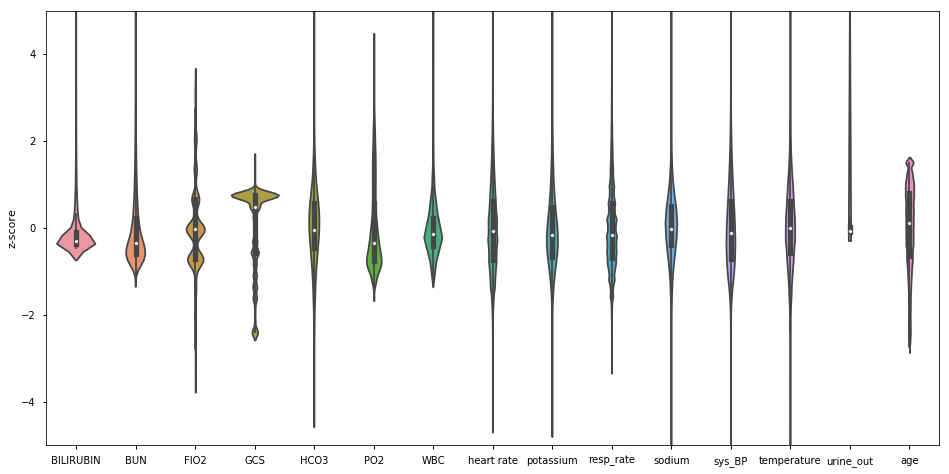

In [17]:
# Calculate the zscore of the data
zscore = (feature_df - feature_df.mean()) / feature_df.std()

# Boxplot of the zscore
boxplot_dims = (16, 8)
fig, ax = plt.subplots(figsize=boxplot_dims)
sns.violinplot(ax=ax, data=zscore)
ax.set_ylabel('z-score')
ax.set_ylim([-5,5])

GCS has range from 1 to 5, data that is out of this range is considered to be the outlier. For the 'age' variable, the range should be within 16 to 91.4 [(the maximum age)](https://mimic.physionet.org/mimictables/patients/). For the rest of the features, we consider the observations as outliers if its z-score is greater or less than 3.5 or -3.5. Then we replace the value of the outliers with NaN.

In [18]:
# Conditions of outliers
for feature in (set(feature_df.columns) - set(['GCS','age'])):
    feature_df.loc[np.abs(zscore[feature]) > 3.5, feature] = np.nan

# Average GCS should be between the lowest (3/3=1) to highest (15/3=5)
feature_df.loc[ (feature_df['GCS'] > 5) | (feature_df['GCS'] < 1), 'GCS'] = np.nan

# The range of age is between 16 and 91.4 
feature_df.loc[ (feature_df['age'] > 91.4) | (feature_df['age'] < 16), 'age'] = np.nan


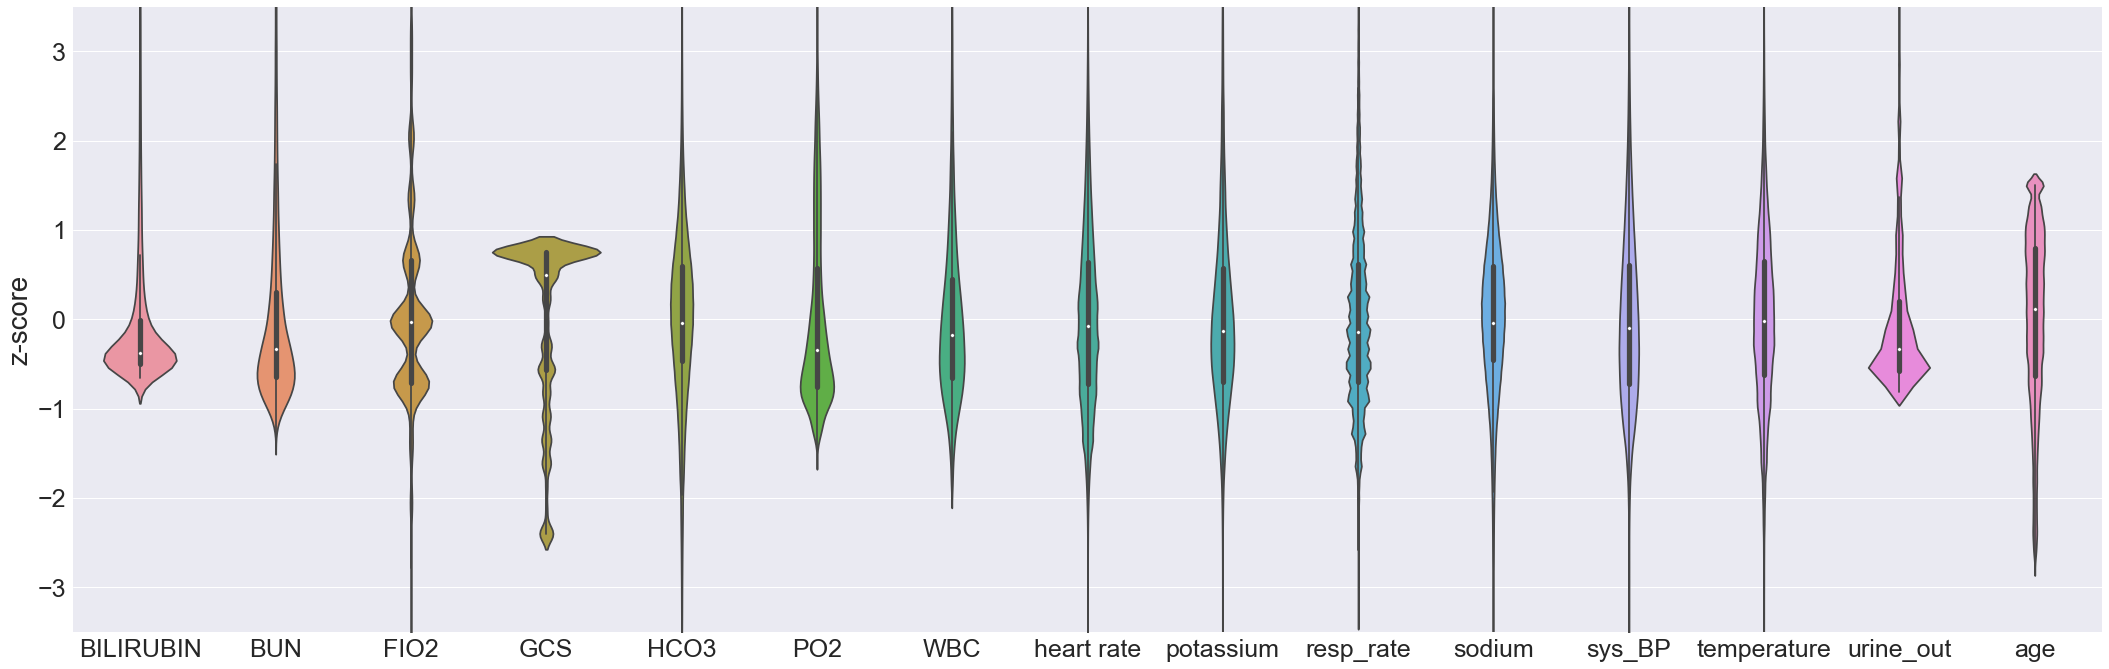

In [19]:
# Calculate the zscore of the data
zscore = (feature_df - feature_df.mean()) / feature_df.std()

# Boxplot of the zscore
boxplot_dims = (30, 10)
sns.set(font_scale=2.5)
fig, ax = plt.subplots(figsize=boxplot_dims)
sns.violinplot(ax=ax, data=zscore)
ax.set_ylabel('z-score')
ax.set_ylim([-3.5,3.5])
if not os.path.exists('plot'):
    os.makedirs('plot')
plt.tight_layout()
plt.savefig('plot/distribution_of_z-score')
plt.show() 
plt.close()

### Feature correlation

Next, we would like to the correlation among each features.

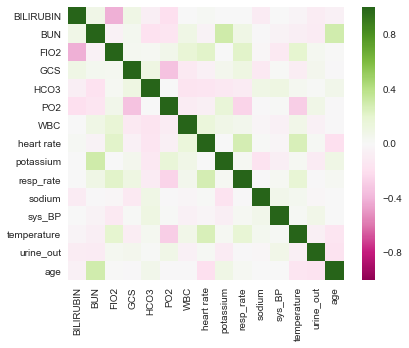

,BILIRUBIN,BUN,FIO2,GCS,HCO3,PO2,WBC,heart rate,potassium,resp_rate,sodium,sys_BP,temperature,urine_out,age
BILIRUBIN,1.000000,0.084949,-0.417520,0.093124,-0.080506,-0.202875,-0.004729,0.017654,-0.000558,-0.003573,-0.107307,-0.005067,-0.032358,-0.100774,-0.060121
BUN,0.084949,1.000000,-0.048806,0.041355,-0.186975,-0.152698,0.087703,-0.039634,0.300214,0.087007,-0.012524,-0.045894,-0.074448,-0.103864,0.291713
FIO2,-0.417520,-0.048806,1.000000,0.033098,0.024963,0.066359,0.168559,0.217693,-0.000389,0.216232,-0.022445,-0.118602,0.200823,0.033038,0.000894
GCS,0.093124,0.041355,0.033098,1.000000,0.104613,-0.336717,-0.123843,-0.058132,0.047847,0.108720,-0.120784,0.014297,-0.089134,0.047995,-0.013157
HCO3,-0.080506,-0.186975,0.024963,0.104613,1.000000,-0.004569,-0.165576,-0.159880,-0.132456,-0.106846,0.090062,0.107411,0.034297,0.007984,0.068086
PO2,-0.202875,-0.152698,0.066359,-0.336717,-0.004569,1.000000,-0.094996,-0.068285,0.159274,-0.251019,-0.012576,0.013034,-0.281525,0.084234,-0.008825
WBC,-0.004729,0.087703,0.168559,-0.123843,-0.165576,-0.094996,1.000000,0.143979,0.085844,0.059692,-0.031238,-0.056317,0.076042,-0.055682,-0.010598
heart rate,0.017654,-0.039634,0.217693,-0.058132,-0.159880,-0.068285,0.143979,1.000000,-0.003631,0.278479,0.009188,-0.030544,0.264115,0.015773,-0.201844
potassium,-0.000558,0.300214,-0.000389,0.047847,-0.132456,0.159274,0.085844,-0.003631,1.000000,0.025003,-0.172057,-0.077325,0.024961,-0.104999,0.093242
resp_rate,-0.003573,0.087007,0.216232,0.108720,-0.106846,-0.251019,0.059692,0.278479,0.025003,1.000000,-0.008487,0.024290,0.175112,-0.008590,0.023649


In [20]:
# calculate the correlation matrix
corr_matrix = feature_df.corr()

# plot the heatmap
boxplot_dims = (6, 5)
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=boxplot_dims)
sns.heatmap(ax=ax, data=corr_matrix, 
            xticklabels=corr_matrix.columns, 
            yticklabels=corr_matrix.columns,
            cmap='PiYG',
            vmin = -1,
            vmax = 1)
if not os.path.exists('plot'):
    os.makedirs('plot')
plt.tight_layout()
plt.savefig('plot/corr_matrix')
plt.show() 
plt.close()

corr_matrix

### Data resampling, interpolation, and imputation

We resample the irregular time series into regular time series with time interval of 2 hours. Then, we interpolate the time series by each patient. Finally, we impute using the mean if the whole time series is missing.

In [21]:
# Resample the time index
time_index = pd.date_range(datetime.date.today(), periods=12, freq='2h', name='time')
resampled_df = feature_df.groupby(level=0).apply(lambda group:group.resample('2h', level=1).mean())
resampled_df = resampled_df.groupby(level=0).apply(lambda group: group.reset_index(level=0, drop=True).reindex(time_index))


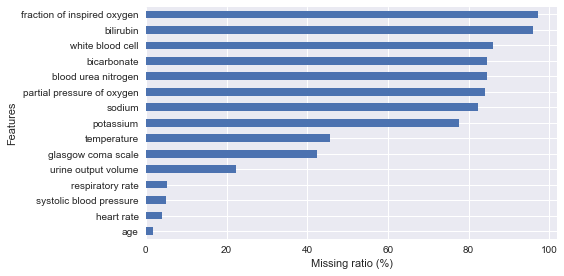

In [22]:
# create a label
labels = ['bilirubin', 'blood urea nitrogen', 'fraction of inspired oxygen', 'glasgow coma scale', 'bicarbonate', 
          'partial pressure of oxygen', 'white blood cell', 'heart rate', 'potassium', 'respiratory rate',
          'sodium', 'systolic blood pressure', 'temperature', 'urine output volume', 'age']

# calculate the missing ratio
missing_ratio = (100*(1 - resampled_df.count()/resampled_df.shape[0]))

# replace the label
missing_ratio.index = labels

# sort by values
missing_ratio = missing_ratio.sort_values(ascending=True)

# create a plot to see the missing ratio
plot_dims = (8, 4)
fig, ax = plt.subplots(figsize=plot_dims)
missing_ratio.plot(ax=ax, kind = 'barh')
ax.set_ylabel('Features')
ax.set_xlabel('Missing ratio (%)')
if not os.path.exists('plot'):
    os.makedirs('plot')
plt.tight_layout()
plt.savefig('plot/missing_ratio')
plt.show() 
plt.close()

The missing data is handled by imputation by the following steps:
* apply linear interpolation on the multivariate time series for each patient 
* fill the missing data using the next valid observation for each patient

Some observations are still missing after these imputations, since there is entire missing data for some features for some patients. In this case, we fill the time series using the mean of all observations.

In [23]:
from sklearn.preprocessing import Imputer, MinMaxScaler

# Interpolate
resampled_df = resampled_df.groupby(level=0).apply(lambda group: group.interpolate())
resampled_df = resampled_df.groupby(level=0).apply(lambda group: group.fillna(method='backfill'))

# Imputate using the mean if the whole time series is missing
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputed_data = imp.fit_transform(resampled_df)

# scale the data to range of [0,1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(imputed_data)

# Store the processed dataframe as processed_df
processed_feature_df = pd.DataFrame(scaled_data, index=resampled_df.index, columns=resampled_df.columns)

We plot an example of the original data and the processed data.

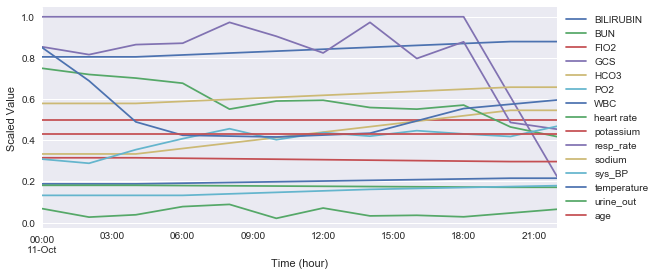

In [24]:
# plot the time series for a patient
plot_dims = (8, 4)
fig, ax = plt.subplots(figsize=plot_dims)
processed_feature_df.loc[(200003), :].plot(ax=ax)
ax.set_ylabel('Scaled Value')
ax.set_xlabel('Time (hour)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
if not os.path.exists('plot'):
    os.makedirs('plot')
plt.tight_layout()
plt.savefig('plot/An_example_of_imputed_and_transformed_data')
plt.show() 
plt.close()

## Create train, valid, and test data

In [25]:
postives = (target_df['in_hospital_death'] == 1).sum()
negatives = (target_df['in_hospital_death'] == 0).sum()
sum_all = postives + negatives
postives = postives/sum_all*100
negatives = negatives/sum_all*100

print('The percentage of postives and negatives: ', postives, negatives)

The percentage of postives and negatives:  11.4417714143 88.5582285857


The dataset is unbalanced, and it contains about 11.4% of positive samples. In order to preserve the percentage of samples for each class, stratified randomized split is applied to the dataset. The size of the test size is set to be 20% of the original dataset, which contains 4806 samples. On the other hand, the training dataset contains 19220 samples. Finally, the training and testing datasets are split into 'X_train', 'X_test', 'y_train', and 'y_test'.

In [26]:
# Import train_test_split
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Turns the data to list of data
features = []
targets = []

for icustay_id, sub_df in processed_feature_df.groupby(level=0):
    features.append(processed_feature_df.loc[icustay_id,:].values)
    targets.append(target_df.loc[icustay_id, :].values)

# only consider the label
target_vector = np.array(targets)[:,0] 

# Apply stratifiedShuffleSplit to conserve the imbalanced set
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indexs  = next(iter(sss.split(features, target_vector)))

X_train = [features[index] for index in indexs[0]]
y_train = [targets[index] for index in indexs[0]]
X_test = [features[index] for index in indexs[1]]
y_test = [targets[index] for index in indexs[1]]

# Show the results of the split
print("Training set has {} samples.".format(len(X_train)))
print("Testing set has {} samples.".format(len(X_test)))

# Check the folds are made by preserving the percentage of samples for each class
difference = abs(sum(np.array(y_train)[:,0])/len(y_train) - sum(np.array(y_test)[:,0])/len(y_test))*100
print('The difference of the fraction of positive samples between train and test datasets is: {:3f}%'.format(difference))

Training set has 19220 samples.
Testing set has 4806 samples.
The difference of the fraction of positive samples between train and test datasets is: 0.002821%


The feature data is a list of array, and it is better to convert the data that can be stored using csv format. Also, remove the origin ICU-stay ID and time interval.

In [22]:
# create an index contains id and time for training data
time_index = np.arange(0,12,1)
id_index = np.arange(0, len(X_train), 1)
combined_index = pd.MultiIndex.from_product([id_index, time_index], names=['id', 'time'])

# Convert the training data into dataframe
X_train = pd.DataFrame(np.concatenate(X_train, axis =0), index=combined_index, columns=processed_feature_df.columns)
y_train = pd.DataFrame(np.array(y_train), index=id_index, columns=target_df.columns)
y_train.index.name = 'id'

In [23]:
# create an index from testing data
id_index = np.arange(len(y_train), len(y_train) + len(y_test), 1)
combined_index = pd.MultiIndex.from_product([id_index, time_index], names=['id', 'time'])

# convert the testing data into dataframe
X_test = pd.DataFrame(np.concatenate(X_test, axis=0), index=combined_index, columns=processed_feature_df.columns)
y_test = pd.DataFrame(np.array(y_test), index=id_index, columns=target_df.columns)
y_test.index.name = 'id'

In [24]:
for filename, data in zip(['X_train', 'X_test', 'y_train', 'y_test'], 
                          [X_train, X_test, y_train, y_test]):
    data.to_csv(get_path(filename, 'csv'))